# Testing on only systems that are stable during short integration
**Previous testing of model has included systems which go unstable during the short integration phase. We have decided that this provides a false sense of model performance and are re establishing accuracy metrics to not include said systems.**

Data generated using rebound 3.8.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

We will import the dataset and train using previously derived model parameters 

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
dataset = pd.read_csv(datapath+'oldReboundDirty.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0'])

One of the below functions removes systems that are initially stable from the testing set, while the other does not

In [3]:
def train_test_old(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits
    return train[features], train['Stable'], test[features], test['Stable']

def train_test_stable(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testXold, testYold = train_test_old(dataset, features)
trainX, trainY, testXstable, testYstable = train_test_stable(dataset, features)

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [6]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )

The training data for each example is the same

In [7]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**AUC when tested on all testing systems (original method)**

Text(0.5, 1.0, 'ROC curve when tested on all systems (AUC = 0.953)')

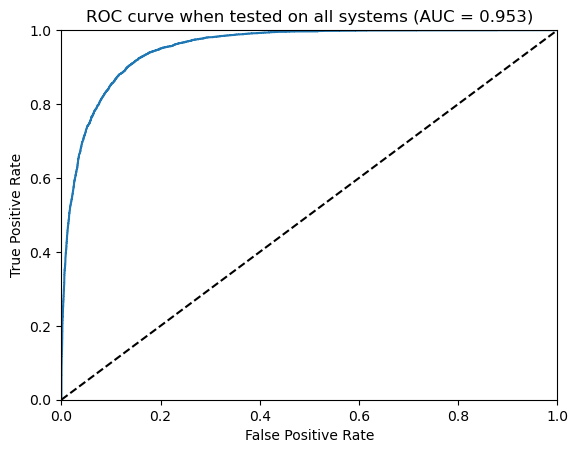

In [8]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testXold, testYold)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve when tested on all systems (AUC = {0:.3f})'.format(roc_auc))

In [9]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
falsePos = fpr[tprthreshindex]
print(f"AUC: {roc_auc} \nFPR: {falsePos}")

AUC: 0.9527061313707524 
FPR: 0.1329466490553035


**AUC when only testing on systems that are stable during short integration phase**

Text(0.5, 1.0, 'ROC curve when tested on only initially stable systems (AUC = 0.949)')

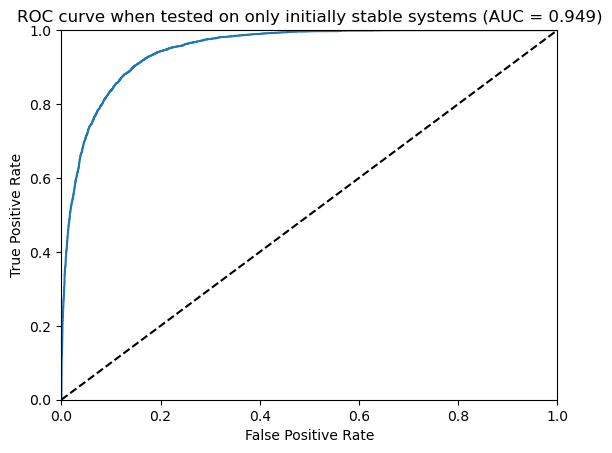

In [10]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testXstable, testYstable)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve when tested on only initially stable systems (AUC = {0:.3f})'.format(roc_auc))

In [11]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
falsePos = fpr[tprthreshindex]
print(f"AUC: {roc_auc} \nFPR: {falsePos}")

AUC: 0.9489954178187129 
FPR: 0.14488031081589173


# Discussion
We can see that the AUC when testing on only initially stable systems in notable lower. This provides a more realistic sense of SPOCKs performance since we realistically do not care about predictions on systems who go unstable during their short integrations since we are already sure they are unstable